In [1]:
# Funciones caseras para estandarizar la computación
#from Functions import *
# Para el acceso a los ficheros
import os
# Para las imágenes
import numpy as np
import cv2 # OpenCV-Python
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
# Para controlar el tiempo
import time
import tensorflow as tf
import tensorflow_hub as hub
from Functions.object_detection import *

In [2]:
module_handle = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
detector_mobilenet = hub.load(module_handle).signatures['serving_default']

In [3]:
# SIFT feature detector/descriptor
sift = cv2.xfeatures2d.SIFT_create()

In [10]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_local/"
examples_path = "../../Circuito_Almeria_171021/Iniciados/Examples/"

In [7]:
moto_example = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

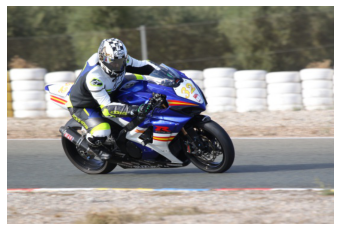

In [8]:
plt.imshow(cv2.cvtColor(moto_example, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [9]:
sift_points_examples_list = list()
folder_names_list = list()
for example_name in os.listdir(examples_path):
    folder_names_list.append(example_name[:-4])
    example = cv2.cvtColor(cv2.imread(os.path.join(examples_path, example_name)), cv2.COLOR_BGR2RGB)
    scale_percent = 10
    # SE CALCULAN LAS NUEVAS DIMENSIONES DE LA IMAGEN
    width = int(example.shape[1] * scale_percent / 100)
    height = int(example.shape[0] * scale_percent / 100)
    dim = (width, height)
    # SE RESCALA LA IMAGEN
    resized_example = cv2.resize(example, dim, interpolation = cv2.INTER_AREA)
    ### OBJECT DETECTION ###
    converted_img = tf.image.convert_image_dtype(resized_example, tf.uint8)[tf.newaxis, ...]
    result = apply_detection(converted_img, detector_mobilenet)
    boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
    boxes_and_scores = remove_little_score(boxes_and_scores)
    boxes_and_scores = remove_overlaying(boxes_and_scores)
    img_boxed = extract_boxes(example, boxes_and_scores)
    ### SIFT POINTS ###
    kp, des = sift.detectAndCompute(img_boxed[0], None)
    sift_points_examples_list.append(des)
pos2nb_dict = dict(zip(np.arange(len(folder_names_list)), folder_names_list))

In [11]:
img_paths = list()
for folder in os.listdir(data_path):
    for image in os.listdir(os.path.join(data_path, folder)):
        img_paths.append([os.path.join(data_path, folder, image), folder])
df = pd.DataFrame(img_paths, columns = ["image_path", "folder"])
del img_paths

In [12]:
sift_ponts = list()
for image_path in df.image_path:
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)# SE RESCALA LA IMAGEN
    # RESIZING (TODO DELETE)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    ### OBJECT DETECTION ###
    converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
    result = apply_detection(converted_img, detector_mobilenet)
    boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
    boxes_and_scores = remove_little_score(boxes_and_scores)
    boxes_and_scores = remove_overlaying(boxes_and_scores)
    img_boxed = extract_boxes(image, boxes_and_scores)
    ### SIFT POINTS ###
    if not len(img_boxed):
        kp,des = sift.detectAndCompute(image, None)
    else:
        kp, des = sift.detectAndCompute(img_boxed[0], None)
    sift_ponts.append(des)
df["sift_points"] = sift_ponts
del sift_ponts

In [13]:
df.shape

(102, 3)

In [14]:
df.head()

,image_path,folder,sift_points
0,../../Circuito_Almeria_171021/Iniciados/Data_l...,1,"[[107.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1..."
1,../../Circuito_Almeria_171021/Iniciados/Data_l...,1,"[[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0,..."
2,../../Circuito_Almeria_171021/Iniciados/Data_l...,10,"[[4.0, 104.0, 22.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2..."
3,../../Circuito_Almeria_171021/Iniciados/Data_l...,10,"[[7.0, 46.0, 132.0, 44.0, 0.0, 0.0, 0.0, 0.0, ..."
4,../../Circuito_Almeria_171021/Iniciados/Data_l...,11,"[[20.0, 91.0, 8.0, 0.0, 0.0, 5.0, 10.0, 2.0, 1..."


In [21]:
df = df[df.folder != "Examples"]

In [10]:
def sift_cluster_one_example(sift_points_data, sift_points_examples_list = sift_points_examples_list):
    nb_good_matches = list()
    for sift_points_example in sift_points_examples_list:
        # BFMatcher(Brute Force Matcher) with defalut setting
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.knnMatch(sift_points_data, sift_points_example, k=2)
        # Apply ratio test as in David Rowe's paper
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        nb_good_matches.append(len(good_matches))
    return(np.argmax(nb_good_matches))

In [11]:
sift_cluster_one_example(df.sift_points[2002])

33

In [12]:
pred_folder = list()
for sift_points in df.sift_points:
    pred_folder.append(pos2nb_dict[sift_cluster_one_example(sift_points)])

In [13]:
df["pred_folder"] = pred_folder
accuracy = (sum(df.folder == df.pred_folder)-34)/(len(df)-34)
print("Accuracy: " + str(round(accuracy*100, 2)) + "%")

Accuracy: 33.5%


In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df.folder, df.pred_folder)

array([[32,  3,  4, ...,  1,  1, 11],
       [ 5,  9,  0, ...,  1,  1, 13],
       [ 7,  1, 46, ...,  0,  0, 12],
       ...,
       [ 2,  0,  1, ..., 47,  0,  4],
       [ 1,  1,  0, ...,  0, 54,  6],
       [ 2,  2,  2, ...,  0,  0, 53]], dtype=int64)

In [15]:
np.random.seed(42)
rnd_folder = np.random.randint(1,35, len(df)).astype(str)
df["rnd_folder"] = pd.Series(rnd_folder)
accuracy_rnd = sum(df.folder == df["rnd_folder"])/len(df)
print("El modelo lo hace " + str(round(accuracy/accuracy_rnd,2)) + " veces mejor que la asignación aleatoria")

El modelo lo hace 13.61 veces mejor que la asignación aleatoria


In [ ]:
patata

NameError: name 'patata' is not defined

In [4]:
data_path = "../Circuito_Almeria_171021/Iniciados/Data/"
examples_path = "../Circuito_Almeria_171021/Iniciados/Examples/"

In [5]:
moto_example = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [6]:
sift_points_examples_list = list()
folder_names_list = list()
for example_name in os.listdir(examples_path):
    folder_names_list.append(example_name[:-4])
    example = cv2.cvtColor(cv2.imread(os.path.join(examples_path, example_name)), cv2.COLOR_BGR2RGB)
    scale_percent = 100
    # SE CALCULAN LAS NUEVAS DIMENSIONES DE LA IMAGEN
    # width = int(example.shape[1] * scale_percent / 100)
    # height = int(example.shape[0] * scale_percent / 100)
    # dim = (width, height)
    # SE RESCALA LA IMAGEN
    # resized_example = cv2.resize(example, dim, interpolation = cv2.INTER_AREA)
    resized_example = example
    ### OBJECT DETECTION ###
    converted_img = tf.image.convert_image_dtype(resized_example, tf.uint8)[tf.newaxis, ...]
    result = apply_detection(converted_img, detector_mobilenet)
    boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
    boxes_and_scores = remove_little_score(boxes_and_scores)
    boxes_and_scores = remove_overlaying(boxes_and_scores)
    img_boxed = extract_boxes(example, boxes_and_scores)
    ### SIFT POINTS ###
    kp, des = sift.detectAndCompute(img_boxed[0], None)
    sift_points_examples_list.append(des)
pos2nb_dict = dict(zip(np.arange(len(folder_names_list)), folder_names_list))

In [7]:
img_paths = list()
for folder in os.listdir(data_path):
    for image in os.listdir(os.path.join(data_path, folder)):
        img_paths.append([os.path.join(data_path, folder, image), folder])
df = pd.DataFrame(img_paths, columns = ["image_path", "folder"])
del img_paths

In [8]:
sift_ponts = list()
for image_path in df.image_path:
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    ### OBJECT DETECTION ###
    converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
    result = apply_detection(converted_img, detector_mobilenet)
    boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
    boxes_and_scores = remove_little_score(boxes_and_scores)
    boxes_and_scores = remove_overlaying(boxes_and_scores)
    img_boxed = extract_boxes(image, boxes_and_scores)
    ### SIFT POINTS ###
    if not len(img_boxed):
        kp,des = sift.detectAndCompute(image, None)
    else:
        kp, des = sift.detectAndCompute(img_boxed[0], None)
    sift_ponts.append(des)
df["sift_points"] = sift_ponts
del sift_ponts

In [9]:
df.head()

,image_path,folder,sift_points
0,../Circuito_Almeria_171021/Iniciados/Data/1\CI...,1,"[[0.0, 0.0, 0.0, 1.0, 1.0, 33.0, 109.0, 4.0, 1..."
1,../Circuito_Almeria_171021/Iniciados/Data/1\CI...,1,"[[0.0, 0.0, 0.0, 0.0, 1.0, 10.0, 0.0, 0.0, 9.0..."
2,../Circuito_Almeria_171021/Iniciados/Data/1\CI...,1,"[[0.0, 1.0, 1.0, 22.0, 104.0, 25.0, 30.0, 15.0..."
3,../Circuito_Almeria_171021/Iniciados/Data/1\CI...,1,"[[2.0, 2.0, 10.0, 119.0, 86.0, 0.0, 0.0, 0.0, ..."
4,../Circuito_Almeria_171021/Iniciados/Data/1\CI...,1,"[[17.0, 5.0, 0.0, 15.0, 100.0, 0.0, 0.0, 0.0, ..."


In [10]:
def sift_cluster_one_example(sift_points_data, sift_points_examples_list = sift_points_examples_list):
    nb_good_matches = list()
    for sift_points_example in sift_points_examples_list:
        # BFMatcher(Brute Force Matcher) with defalut setting
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.knnMatch(sift_points_data, sift_points_example, k=2)
        # Apply ratio test as in David Rowe's paper
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        nb_good_matches.append(len(good_matches))
    return(np.argmax(nb_good_matches))

In [11]:
%timeit sift_cluster_one_example(df.sift_points[2002])

2.01 s ± 8.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
pred_folder = list()
for sift_points in df.sift_points:
    pred_folder.append(pos2nb_dict[sift_cluster_one_example(sift_points)])

In [13]:
df["pred_folder"] = pred_folder
accuracy = (sum(df.folder == df.pred_folder)-34)/(len(df)-34)
print("Accuracy: " + str(round(accuracy*100, 2)) + "%")

Accuracy: 28.09%


In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df.folder, df.pred_folder)

array([[31,  0,  1, ...,  0,  0, 18],
       [ 6,  8,  0, ...,  0,  2,  8],
       [ 2,  0, 45, ...,  0,  0, 18],
       ...,
       [ 5,  0,  0, ..., 39,  0, 18],
       [ 6,  1,  0, ...,  0, 40, 17],
       [ 7,  0,  1, ...,  1,  0, 54]], dtype=int64)

In [15]:
np.random.seed(42)
rnd_folder = np.random.randint(1,35, len(df)).astype(str)
df["rnd_folder"] = pd.Series(rnd_folder)
accuracy_rnd = sum(df.folder == df["rnd_folder"])/len(df)
print("El modelo lo hace " + str(round(accuracy/accuracy_rnd,2)) + " veces mejor que la asignación aleatoria")

El modelo lo hace 11.41 veces mejor que la asignación aleatoria


In [16]:
examples2_path = "../Circuito_Almeria_171021/Iniciados/Examples2/"

In [17]:
sift_points_examples_list = list()
folder_names_list = list()
for folder in os.listdir(examples2_path):
    folder_names_list.append(folder)
    for image in os.listdir(os.path.join(examples2_path, folder)):
        example = cv2.imread(os.path.join(examples2_path, folder, image))
        scale_percent = 100
        # SE CALCULAN LAS NUEVAS DIMENSIONES DE LA IMAGEN
        # width = int(example.shape[1] * scale_percent / 100)
        # height = int(example.shape[0] * scale_percent / 100)
        # dim = (width, height)
        # SE RESCALA LA IMAGEN
        resized_example = example
        ### OBJECT DETECTION ###
        converted_img = tf.image.convert_image_dtype(resized_example, tf.uint8)[tf.newaxis, ...]
        result = apply_detection(converted_img, detector_mobilenet)
        boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
        boxes_and_scores = remove_little_score(boxes_and_scores)
        boxes_and_scores = remove_overlaying(boxes_and_scores)
        img_boxed = extract_boxes(example, boxes_and_scores)
        ### SIFT POINTS ###
        kp, des = sift.detectAndCompute(img_boxed[0], None)
        sift_points_examples_list.append(des)

In [18]:
sift_points_examples_list_ = []
for i in range(len(sift_points_examples_list)):
    if i%2:
        sift_points_examples_list_.append(np.concatenate((sift_points_examples_list[i-1],sift_points_examples_list[i])))

In [19]:
def sift_cluster_two_examples_top(sift_points_data, sift_points_examples_list = sift_points_examples_list):
    nb_good_matches = list()
    for sift_points_example in sift_points_examples_list:
        # BFMatcher(Brute Force Matcher) with defalut setting
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.knnMatch(sift_points_data, sift_points_example, k=2)
        # Apply ratio test as in David Rowe's paper
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        nb_good_matches.append(len(good_matches))
    return(np.argmax(nb_good_matches))

In [20]:
len(sift_points_examples_list_)

34

In [ ]:
pred_folder = list()
for sift_points in df.sift_points:
    pred_folder.append(pos2nb_dict[sift_cluster_one_example(sift_points,
                                                            sift_points_examples_list=sift_points_examples_list_)])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df.folder, df.pred_folder)

In [ ]:
df["pred_folder_2_together"] = pred_folder
accuracy_2 = (sum(df.folder == df.pred_folder_2_together)-34*2)/(len(df)-34*2)
print("Accuracy: " + str(round(accuracy_2*100, 2)) + "%")

In [ ]:
print("El modelo lo hace " + str(round(accuracy_2/accuracy_rnd,2)) + " veces mejor que la asignación aleatoria")

In [ ]:
patata

In [ ]:
35.88 -> 33% 1photo
43.97 -> 33% 2photos

In [ ]:
39.07 -> together

In [41]:
100/37.99

2.632271650434325

In [42]:
2/5

0.4